#Introduction

Penalty kick shootouts are a key part of tournament soccer. If the match is tied after regulation and/or overtime, a shootout determines the winner. Goalkeepers are crucial in these moments. A goalkeeper who is able to save multiple shots greatly increases his or her team's chance of winning. 

Managers face a tough decision when going into a shootout. Most teams have two or three goalkeepers on the roster, and the starting goalkeeper might not be the best for the specialized skill of blocking shots in a shootout. Several managers will substitute the goalkeeper right before the shootout so the goalkeeper with the highest *save rate* will participate in the shootout. 

But how does a manager determine which goalkeeper has the highest *save rate*? This project explores this question.

## Notes and Caveats

### Assumptions

For simplicity throughout the exercise, we will assume that each goalkeeper has an inherent *true save rate*. This does not change over time or with practice. Whether the goalkeeper saves a given shot is a random variable. The goalkeeper saves the shot with probability *true save rate* or the shot is scored.

### Other Applications

The rest of this notebook will explore how a coach might use data to determine which goalkeeper on her roster has the highest save rate. The applications for this kind of algorithm, however, are much broader than sports. Similar approaches could be used for:
- a marketing analyst determining which ad has the highest click-through rate
- a drug manufacturer determining which drug is most effective
- a manager determining which price is most likely to convince a customer to buy a product

### Attribution

For much of what I learned I am indebted to [The Lazy Programmer](https://swirecc.udemy.com/user/lazy-programmer/) who has a fantastic course on Udemy on this topic. 

If you are interested in learning more about A/B Testing, I highly recommend the [course](https://swirecc.udemy.com/course/bayesian-machine-learning-in-python-ab-testing/). 



# Approach 1: Classical A/B Testing

Let's start with the *Classical* approach from statistics (this is also the *frequentist method*)  

The coach has two goalkeepers on her roster: Buffon and Casillas. She wants to know which goalkeeper has a higher *save rate*. The coach plans an experiment.

> During training sessions, each goalkeeper will face a number of penalty kick shots from several different shooters. The coach will record whether each shot is saved and use this data to determine which goalkeeper has the higher save rate or if they are the same.

*How many shots should each goalkeeper face during the experiment?*

The coach knows that the average save rate among all goalkeepers is about [25%](https://theanalyst.com/2024/05/premier-league-penalties-like-free-goal). She reasons that it is important to be able to detect a difference of 5% or greater between the true save rates of each goalkeeper. 

To decide how many shots each goalkeeper should face, the coach googles around online and lands on this [calculator](https://www2.ccrb.cuhk.edu.hk/stat/proportion/Casagrande.htm) from the center for clinical research and biostats. 

In [0]:
gk1 = 0.25
gk2 = 0.3 #the minimum difference the coach wants to detect

r=1 #each goalkeeper should face the same number of shots
alpha = 0.25 #type I error, rejecting true null. Coach is not too concerned if she thinks a goalkeeper is better when they are actually the same. The cost is using an unnecessary substitute, which is not as critical as the other error... 
beta = 0.01 #type II error, failing to reject false null. Coach really wants to make sure she knows the difference if there is one
power = 1 - beta 

The coach puts the values into the calculator and...

![picture of sample calculator](pics/sample_calc.png)

Each goalkeeper needs to face 1964 shots to ensure we pick up the difference!!!

## Simulation

Let's take a brief pause from the story and simulate what this would look like.

In [0]:
#set up the experiment
import numpy as np
from scipy.stats import ttest_ind

def t_experiment(p1_name, p1, p2_name, p2, n, seed):
    np.random.seed(seed)  # Set the seed for reproducibility

    #simulate each goalkeeper facing n shots. 1 is a save, 0 is a goal
    p1_results = np.random.choice([1, 0], size=n, p=[p1, 1-p1])
    p2_results = np.random.choice([1, 0], size=n, p=[p2, 1-p2])

    # Perform a 2-sided test
    t_stat, p_value = ttest_ind(p1_results, p2_results, alternative='two-sided')

    #interpret test
    if p_value < alpha:
        r = 'GOALKEEPERS HAVE STATISTICALLY DIFFERENT SAVE RATES'
    else:
        r = 'GOALKEEPERS HAVE STATISTICALLY EQUIVALENT SAVE RATES'

    #print results
    print(p1_name, "observed save rate:", p1_results.mean())
    print(p2_name, "observed save rate:", p2_results.mean())
    print('t-statistic:', t_stat)
    print('p-value:', p_value)
    print()
    print(r)

### Scenario 1

In scenario 1, let's say Buffon has a save rate of 25% and Casillas has a save rate of 30%

In [0]:
buffon_rate = 0.25
casillas_rate = 0.3
n=1964
seed=123 #for reproducibility

t_experiment('Buffon', buffon_rate, 'Casillas', casillas_rate, n, 123)

Buffon observed save rate: 0.25712830957230143
Casillas observed save rate: 0.29989816700611
t-statistic: -2.9925444155512966
p-value: 0.0027838473919743778

GOALKEEPERS HAVE STATISTICALLY DIFFERENT SAVE RATES


We correctly identified that Casillas is the better goalkeeper

### Scenario 2 

But now let's say they are a bit closer. Buffon's save rate is 28% and Casillas's is 30%

In [0]:
buffon_rate = 0.28
casillas_rate = 0.3
n=1964
seed=123 #for reproducibility

t_experiment('Buffon', buffon_rate, 'Casillas', casillas_rate, n, 123)

Buffon observed save rate: 0.285132382892057
Casillas observed save rate: 0.29989816700611
t-statistic: -1.017011955201561
p-value: 0.30921041040514585

GOALKEEPERS HAVE STATISTICALLY EQUIVALENT SAVE RATES


We spent nearly 4000 penalty kicks to not even pick up the different save rates

### Scenario 3

Now let's say the opposite, Casillas is much better than Buffon. Buffon's save rate is 20% and Casillas's is 30%

In [0]:
buffon_rate = 0.2
casillas_rate = 0.3
n=1964
seed=123 #for reproducibility

t_experiment('Buffon', buffon_rate, 'Casillas', casillas_rate, n, 123)

Buffon observed save rate: 0.1985743380855397
Casillas observed save rate: 0.29989816700611
t-statistic: -7.3892208234977765
p-value: 1.7948181949503555e-13

GOALKEEPERS HAVE STATISTICALLY DIFFERENT SAVE RATES


Our experiment clearly picks up the difference. But did we need to shoot nearly 4000 penalty kicks to learn that Casillas is superior? 

No. We could have gotten the same information with each goalkeeper facing only 40 shots (2% of the original planned experiment)

In [0]:
buffon_rate = 0.2
casillas_rate = 0.3
n=40
seed=123 #for reproducibility

t_experiment('Buffon', buffon_rate, 'Casillas', casillas_rate, n, 123)

Buffon observed save rate: 0.1
Casillas observed save rate: 0.25
t-statistic: -1.7782469350914571
p-value: 0.07926026496163022

GOALKEEPERS HAVE STATISTICALLY DIFFERENT SAVE RATES


## Conclusion

Our simulation laid bare some of the drawbacks of the classical approach to this problem:

- The coach does not want to spend hours taking 4000 penalty kicks. That time could be spent on more impactful training
- If the goalkeepers have similar, but not *equivalent*, save rates (as in scenario 2), we still will not identify the correct goalkeeper
- If the goalkeepers are vastly different (as in scenario 3), we don't want to complete the experiment
- While there are tests (like the [Chi-squared](https://en.wikipedia.org/wiki/Chi-squared_test)) that scale to multiple goalkeepers, they often only test if one goalkeeper is _different_, not which one is best
- What if the team faces a shootout before they can complete the experiment? They need a way to choose which goalkeeper with incomplete data

This exposes a tension called *The Explore Exploit Dilemma*.

On one hand we want to **_explore_** and collect more data (have both goalkeepers face more shots).

On the other hand, we want to _**exploit**_ and make sure the better goalkeeper faces as many shots as possible, since he will save more.

Our first approach does not handle this tension in a satisfactory way. Let's turn to a new way of thinking.

#Approach 2: Epsilon Greedy

The team has made a couple additions to its roster. First, the team has added a new goalkeeper named Neuer. The coach now has to select between the three goalkeepers which has the best save rate.

The team has also added an analyst to use data to improve performance. The coach meets with the analyst and pitches him the problem of deciding which goalkeeper has the highest save rate. The coach wants to vet what the analyst suggests before doing the experiment, so they decide to simulate the analyst's approach and talk about the results.

The analyst proposes this experiment.

> Assume all goalkeepers have a save rate of 0. We then select a random number between 1 and 10.
- If we select 1, choose a goalkeeper at random and have them face the next shot. Update our estimated save rate for that goalkeeper based on if they save the shot or not.
- If we select a number between 2 and 10, choose the goalkeeper with the highest estimated save rate to face the next shot. Update our estimated save rate for that goalkeeper based on if they save the shot or not.  

## Simulation

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#goalkeeper colors
blue = '#0358B4' #italian blue
blue_shade = '#afd5fe'
red = '#F81635' #spanish red
red_shade = '#fc9ca9'
teal = '#056E73' #german retro teal
teal_shade = '#89fad8'

#generic colors
black = '#000000' #actuals
gray =  '#BCC3C1' #uncertainty
orange = '#FF7F0E' #target

### Code for Simulation

In [0]:
#set up a class to model each goalkeeper
class Goalkeeper:
    def __init__(self, p, name):
        self.p = p #p is the true save rate
        self.p_estimate = 0 #start with an estimate of 0
        self.N = 0 #samples collected so far
        self.name = name #assign name to goalkeeper

    def face_shot(self):
        #save the shot with probability p
        return np.random.random() < self.p
    
    def update(self, x):
        #x is 0 or 1
        self.N += 1 #record the faced shot
        self.p_estimate = ((self.N - 1)*self.p_estimate + x) / self.N #update our estimate of p

In [0]:
def experiment(num_trials, epsilon, gk_save_rates, gk_names):
    """
    Run an epsilon-greedy experiment

    num_trials (int): the number of trials in the experiment
    epsilon (float): the probability of exploration, needs to be between 0 and 1
    gk_save_rates (list of floats): the true save rates of each goalkeeper
    gk_names (list of strings): the names of each goalkeeper (must be same order as rates)

    df (dataframe): the results of the experiment 
    """

    #get a list of all goalkeepers
    gks = [Goalkeeper(p, name) for p, name in zip(gk_save_rates, gk_names)]

    #initialize results
    trial_ids = []
    exploit_results = []
    gk_results = []
    save_results = []
    p_est_results = []
    chosen_results = []
     
    #For each trial in the experiment, decided whether to exploit, select your gk, and face the shot
    for i in range(num_trials):
        #SELECT GK
        trial_ids.append(i+1) #record trial id

        #if the random value is less than epsilon, we explore by choosing a goalkeeper at random 
        if np.random.random() < epsilon:
            exploit_results.append(False) #record explore
            gk_selected = np.random.randint(len(gks)) #choose a goalkeeper at random
            gk_results.append(gks[gk_selected].name) #record which gk we selected
        else: #otherwise use the best gk
            exploit_results.append(True) #recrod exploit
            gk_selected = np.argmax([gk.p_estimate for gk in gks]) #choose gk with current best rate
            gk_results.append(gks[gk_selected].name) #record which gk we selected

        #FACE THE SHOT

        #face the shot. 1 if a save, 0 if a goal
        save = gks[gk_selected].face_shot()
        #udpate results array
        save_results.append(save)
        #update the estimate of gk save rate
        gks[gk_selected].update(save)
        #record estimates
        p_est_results.append([gk.p_estimate for gk in gks])
        #record chosen gk after this trial
        chosen_results.append(gks[np.argmax([gk.p_estimate for gk in gks])].name)

    #determine array of optimal choice
    opt = gks[np.argmax([gk.p for gk in gks])].name #optimal gk
    opt_results = [g == opt for g in gk_results]
    
    #compile results in a dataframe
    df = pd.DataFrame({
        **{
            'trial_id': trial_ids,
            'exploit': exploit_results,
            'goalkeeper': gk_results,
            'optimal_goalkeeper': opt_results,
            'save': save_results,
            },
        **{gks[i].name+'_est_p': [x[i] for x in p_est_results] for i in range(len(gks))},
        **{
            'top_goalkeeper': chosen_results,
            }
        }
                      )
    
    #add true save rates
    for g in gks:
        df[g.name+'_p'] = g.p
    
    #Add cumulative results
    df['cumulative_exploit'] = df['exploit'].cumsum()
    df['cumulative_exploit_rate'] = df['cumulative_exploit'] / df['trial_id']
    df['target_exploit_rate'] = 1-epsilon
    df['cumulative_optimal_goalkeeper'] = df['optimal_goalkeeper'].cumsum()
    df['cumulative_optimal_rate'] = df['cumulative_optimal_goalkeeper'] / df['trial_id']
    df['target_optimal_rate'] = 1
    df['cumulative_saves'] = df['save'].cumsum()
    df['cumulative_save_rate'] = df['cumulative_saves'] / df['trial_id']
    df['target_save_rate'] = np.max([gk.p for gk in gks])
    
    #record parameters
    df['num_trials'] = num_trials
    df['epsilon'] = epsilon
    
    return df

In [0]:
def simulation(num_experiments, num_trials, epsilon, gk_save_rates, gk_names):
    """
    Run a simulation of epsilon greedy experiments

    num_experiments (int): the number of experiments in the simulation
    num_trials (int): the number of trials per experiment
    epsilon (float): the probability of exploration, needs to be between 0 and 1
    gk_save_rates (list of floats): the true save rates of each goalkeeper
    gk_names (list of strings): the names of each goalkeeper (must be same order as rates)

    sim_df (dataframe): the results of the simulation 
    """

    #initialize df
    i = 1
    np.random.seed(i) #set seed
    sim_df = experiment(num_trials, epsilon, gk_save_rates, gk_names)
    sim_df['experiment_id'] = i

    #iterate through other trials
    for i in range(1, num_experiments):
        np.random.seed(i+1)  #set seed
        df = experiment(num_trials, epsilon, gk_save_rates, gk_names)
        df['experiment_id'] = i+1
        sim_df = pd.concat([sim_df, df])

    return sim_df


### Code to Plot Results

#### Experiment

In [0]:
def plot_exploit_rate_experiment(df):
    """
    Given a dataframe output from a single experiment, plot the cumulative exploit rate
    """

    fig, ax = plt.subplots(figsize=(6, 4))

    #plot target and actual exploit rates
    ax.plot(df["trial_id"], df["cumulative_exploit_rate"], label='Actual Exploit Rate', color=black)
    ax.plot(df["trial_id"], df["target_exploit_rate"], label='Target Exploit Rate', color=orange, linestyle="--")

    #y should be betwee 0 and 1
    ax.set_ylim(0, 1) 

    #labels
    ax.set_xlabel('Trial ID')
    ax.set_ylabel('Actual Exploit Rate')
    ax.set_title('Cumulative Exploit Rate over Trials', fontsize=10, loc='left')
    ax.legend(fontsize=8)

    plt.show()

In [0]:
def plot_save_rate_experiment(df):
    """
    Given a dataframe output from a single experiment, plot the cumulative save rate
    """

    fig, ax = plt.subplots(figsize=(6, 4))

    #plot target and actual exploit rates
    ax.plot(df["trial_id"], df["cumulative_save_rate"], label='Actual Save Rate', color=black)
    ax.plot(df["trial_id"], df["target_save_rate"], label='Target Save Rate', color=orange, linestyle="--")

    #y should be betwee 0 and 1
    ax.set_ylim(0, 1) 

    #labels
    ax.set_xlabel('Trial ID')
    ax.set_ylabel('Actual Save Rate')
    ax.set_title('Cumulative Save Rate over Trials', fontsize=10, loc='left')
    ax.legend(fontsize=8)

    plt.show()

In [0]:
def plot_optimal_rate_experiment(df):
    """
    Given a dataframe output from a single experiment, plot the cumulative optimal rate
    """

    fig, ax = plt.subplots(figsize=(6, 4))

    #plot target and actual exploit rates
    ax.plot(df["trial_id"], df["cumulative_optimal_rate"], label='Actual Optimal Rate', color=black)
    ax.plot(df["trial_id"], df["target_optimal_rate"], label='Target Optimal Rate', color=orange, linestyle="--")

    #y should be betwee 0 and 1
    ax.set_ylim(0, 1.05) 

    #labels
    ax.set_xlabel('Trial ID')
    ax.set_ylabel('Actual Optimal Rate')
    ax.set_title('Cumulative Optimal Rate over Trials', fontsize=10, loc='left')
    ax.legend(fontsize=8)

    plt.show()

In [0]:
def plot_p_est_experiment(df):
    """
    Given a dataframe output from a single experiment, plot the estimated and true save rates for each goalkeeper over time
    """

    fig, ax = plt.subplots(figsize=(6, 4))

    #plot target and actual exploit rates
    ax.plot(df["trial_id"], df["Buffon_est_p"], label='Buffon Estimated Save Rate', color=blue_shade)
    ax.plot(df["trial_id"], df["Buffon_p"], label='Buffon True Save Rate', color=blue, linestyle="--")

    ax.plot(df["trial_id"], df["Casillas_est_p"], label='Casillas Estimated Save Rate', color=red_shade)
    ax.plot(df["trial_id"], df["Casillas_p"], label='Casillas True Save Rate', color=red, linestyle="--")

    ax.plot(df["trial_id"], df["Neuer_est_p"], label='Neuer Estimated Save Rate', color=teal_shade)
    ax.plot(df["trial_id"], df["Neuer_p"], label='Neuer True Save Rate', color=teal, linestyle="--")

    #y should be betwee 0 and 1
    ax.set_ylim(0, 1) 

    #labels
    ax.set_xlabel('Trial ID')
    ax.set_ylabel('Save Rate')
    ax.set_title('Estimated Save Rates over Trials', fontsize=10, loc='left')
    ax.legend(fontsize=8)

    plt.show()

In [0]:
def plot_top_goalkeeper_experiment(df):
    """
    Given a dataframe output from a single experiment, plot the estimated best goalkeeper over time
    """

    # PREPARE DATAFRAME

    #map gk_names to colors
    colors = ['blue', 'red', 'teal']
    color_map = {'Buffon': colors[0], 'Casillas': colors[1], 'Neuer': colors[2]}

    #create df for heatmap. experiments are rows; columns are trials
    experiment_ids = df['experiment_id'].unique()
    trial_ids = df['trial_id'].unique()
    heatmap_data = pd.DataFrame(index=experiment_ids, columns=trial_ids)

    #fill heatmap using 'top_goalkeeper' column mapped to color
    for index, row in df.iterrows():
        goalkeeper = row['top_goalkeeper']
        trial_id = row['trial_id']
        experiment_id = row['experiment_id']
        heatmap_data.loc[experiment_id, trial_id] = color_map[goalkeeper]

    #convert colors to numeric values for heatmap
    color_to_num = {color: i for i, color in enumerate(colors)}
    heatmap_data_numeric = heatmap_data.replace(color_to_num)

    # PLOTTING

    #plot heatmap
    fig, ax = plt.subplots(figsize=(15, 2))
    sns.heatmap(heatmap_data_numeric, cmap=colors, cbar=False, ax=ax)

    #label experiment id
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_ylabel('Experiment ID')

    #label every 100th trial id
    ax.set_xticks(range(0, max(trial_ids), 100))
    ax.set_xticklabels(range(0, max(trial_ids), 100), rotation=0)
    ax.set_xlabel('Trial ID')

    #set title
    ax.set_title('Top Goalkeeper After Each Trial', fontsize=10, loc='left')
    #add legend
    handles = [plt.Rectangle((0,0),1,1, color=color_map[gk]) for gk in color_map]
    ax.legend(handles, color_map.keys(), title="Goalkeepers", bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.show()

#### Simulation

In [0]:
def plot_exploit_rate_simulation(df):
    """
    Given a dataframe output from a simulation, plot the cumulative exploit rate
    """

    #aggregate experiments
    df_grp = (
        df
        .groupby('trial_id')
        .agg(
            exploit_rate_mu=('cumulative_exploit_rate', 'mean'),
            exploit_rate_std=('cumulative_exploit_rate', 'std'),
            target_exploit_rate=('target_exploit_rate', 'max')
            )
    )

    #reset index
    df_grp = df_grp.reset_index()

    #calculate range
    df_grp['exploit_rate_max'] = df_grp['exploit_rate_mu'] + df_grp['exploit_rate_std']
    df_grp['exploit_rate_min'] = df_grp['exploit_rate_mu'] - df_grp['exploit_rate_std']

    #plot data
    fig, ax = plt.subplots(figsize=(6, 4))

    #plot average and target rates
    ax.plot(df_grp["trial_id"], df_grp["exploit_rate_mu"], label='Avg. Exploit Rate', color=black)
    ax.plot(df_grp["trial_id"], df_grp["target_exploit_rate"], label='Target Exploit Rate', color=orange, linestyle="--")

    # Shade between standard deviation
    ax.fill_between(df_grp["trial_id"], df_grp["exploit_rate_min"], df_grp["exploit_rate_max"], color=gray, label='Std. Dev.')

    #y should be betwee 0 and 1
    ax.set_ylim(0, 1.05) 

    #labels
    ax.set_xlabel('Trial ID')
    ax.set_ylabel('Exploit Rate')
    ax.set_title('Average Cumulative Exploit Rate over Trials', fontsize=10, loc='left')
    ax.legend(fontsize=8)

    plt.show()

In [0]:
def plot_save_rate_simulation(df):
    """
    Given a dataframe output from a simulation, plot the cumulative save rate
    """

    #aggregate experiments
    df_grp = (
        df
        .groupby('trial_id')
        .agg(
            save_rate_mu=('cumulative_save_rate', 'mean'),
            save_rate_std=('cumulative_save_rate', 'std'),
            target_save_rate=('target_save_rate', 'max')
            )
    )

    #reset index
    df_grp = df_grp.reset_index()

    #calculate range
    df_grp['save_rate_max'] = df_grp['save_rate_mu'] + df_grp['save_rate_std']
    df_grp['save_rate_min'] = df_grp['save_rate_mu'] - df_grp['save_rate_std']

    #plot data
    fig, ax = plt.subplots(figsize=(6, 4))

    #plot average and target rates
    ax.plot(df_grp["trial_id"], df_grp["save_rate_mu"], label='Avg. Save Rate', color=black)
    ax.plot(df_grp["trial_id"], df_grp["target_save_rate"], label='Target Save Rate', color=orange, linestyle="--")

    #shade between standard deviation
    ax.fill_between(df_grp["trial_id"], df_grp["save_rate_min"], df_grp["save_rate_max"], color=gray, label='Std. Dev.')

    #y should be betwee 0 and 1
    ax.set_ylim(0, 1.05) 

    #labels
    ax.set_xlabel('Trial ID')
    ax.set_ylabel('Save Rate')
    ax.set_title('Average Cumulative Save Rate over Trials', fontsize=10, loc='left')
    ax.legend(fontsize=8)

    plt.show()

In [0]:
def plot_optimal_rate_simulation(df, title='Average Cumulative Optimal Rate over Trials'):
    """
    Given a dataframe output from a simulation, plot the cumulative optimal rate
    """

    #aggregate experiments
    df_grp = (
        df
        .groupby('trial_id')
        .agg(
            optimal_rate_mu=('cumulative_optimal_rate', 'mean'),
            optimal_rate_std=('cumulative_optimal_rate', 'std'),
            target_optimal_rate=('target_optimal_rate', 'max')
            )
    )

    #reset index
    df_grp = df_grp.reset_index()

    #calculate range
    df_grp['optimal_rate_max'] = df_grp['optimal_rate_mu'] + df_grp['optimal_rate_std']
    df_grp['optimal_rate_min'] = df_grp['optimal_rate_mu'] - df_grp['optimal_rate_std']

    #plot data
    fig, ax = plt.subplots(figsize=(6, 4))

    #plot average and target rates
    ax.plot(df_grp["trial_id"], df_grp["optimal_rate_mu"], label='Avg. Optimal Rate', color=black)
    ax.plot(df_grp["trial_id"], df_grp["target_optimal_rate"], label='Target Optimal Rate', color=orange, linestyle="--")

    #shade between standard deviation
    ax.fill_between(df_grp["trial_id"], df_grp["optimal_rate_min"], df_grp["optimal_rate_max"], color=gray, label='Std. Dev.')

    #y should be betwee 0 and 1
    ax.set_ylim(0, 1.05) 

    #labels
    ax.set_xlabel('Trial ID')
    ax.set_ylabel('Optimal Rate')
    ax.set_title(title, fontsize=10, loc='left')
    ax.legend(fontsize=8)

    plt.show()

In [0]:
def plot_p_est_simulation(df):
    """
    Given a dataframe output from a simulation, plot the estimated and true save rates for each goalkeeper over time
    """

    #aggregate experiments
    df_grp = (
        df
        .groupby('trial_id')
        .agg(
            Buffon_est_p_mu=('Buffon_est_p', 'mean'),
            Buffon_est_p_std=('Buffon_est_p', 'std'),
            Buffon_p=('Buffon_p', 'max'),
            Casillas_est_p_mu=('Casillas_est_p', 'mean'),
            Casillas_est_p_std=('Casillas_est_p', 'std'),
            Casillas_p=('Casillas_p', 'max'),
            Neuer_est_p_mu=('Neuer_est_p', 'mean'),
            Neuer_est_p_std=('Neuer_est_p', 'std'),
            Neuer_p=('Neuer_p', 'max'),
            )
    )

    #reset index
    df_grp = df_grp.reset_index()

    #calculate range
    df_grp['Buffon_p_max'] = df_grp['Buffon_est_p_mu'] + df_grp['Buffon_est_p_std']
    df_grp['Buffon_p_min'] = df_grp['Buffon_est_p_mu'] - df_grp['Buffon_est_p_std']
    df_grp['Casillas_p_max'] = df_grp['Casillas_est_p_mu'] + df_grp['Casillas_est_p_std']
    df_grp['Casillas_p_min'] = df_grp['Casillas_est_p_mu'] - df_grp['Casillas_est_p_std']
    df_grp['Neuer_p_max'] = df_grp['Neuer_est_p_mu'] + df_grp['Neuer_est_p_std']
    df_grp['Neuer_p_min'] = df_grp['Neuer_est_p_mu'] - df_grp['Neuer_est_p_std']

    #plot data
    fig, ax = plt.subplots(figsize=(6, 4))

    #plot average and target rates
    ax.plot(df_grp["trial_id"], df_grp["Buffon_est_p_mu"], label='Avg. Buffon Estimated Save Rate', color=blue)
    ax.plot(df_grp["trial_id"], df_grp["Buffon_p"], label='Buffon True Save Rate', color=gray, linestyle="-.")

    #shade between standard deviation
    ax.fill_between(df_grp["trial_id"], df_grp["Buffon_p_min"], df_grp["Buffon_p_max"], color=blue_shade, alpha=0.3, label='Buffon Std. Dev.')

    #plot average and target rates
    ax.plot(df_grp["trial_id"], df_grp["Casillas_est_p_mu"], label='Avg. Casillas Estimated Save Rate', color=red)
    ax.plot(df_grp["trial_id"], df_grp["Casillas_p"], label='Casillas True Save Rate', color=gray, linestyle=":")

    #shade between standard deviation
    ax.fill_between(df_grp["trial_id"], df_grp["Casillas_p_min"], df_grp["Casillas_p_max"], color=red_shade, alpha=0.3, label='Casillas Std. Dev.')

    #plot average and target rates
    ax.plot(df_grp["trial_id"], df_grp["Neuer_est_p_mu"], label='Avg. Neuer Estimated Save Rate', color=teal)
    ax.plot(df_grp["trial_id"], df_grp["Neuer_p"], label='Neuer True Save Rate', color=gray, linestyle="--")

    #shade between standard deviation
    ax.fill_between(df_grp["trial_id"], df_grp["Neuer_p_min"], df_grp["Neuer_p_max"], color=teal_shade, alpha=0.3, label='Neuer Std. Dev.')

    #set the y axis as max of upper limit for any goalkeeper
    y_max = df_grp[['Buffon_p_max', 'Casillas_p_max', 'Neuer_p_max']].max().max() +0.05
    ax.set_ylim(0, y_max) 

    #labels
    ax.set_xlabel('Trial ID')
    ax.set_ylabel('Save Rate')
    ax.set_title('Average Estimated Save Rates over Trials', fontsize=10, loc='left')
    ax.legend(fontsize=8, bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.show()

In [0]:
def plot_top_goalkeeper_simulation(df):
    """
    Given a dataframe output from a simulation, plot the estimated best goalkeeper over time
    """

    # PREPARE DATAFRAME

    #map gk_names to colors
    colors = ['blue', 'red', 'teal']
    color_map = {'Buffon': colors[0], 'Casillas': colors[1], 'Neuer': colors[2]}

    #create df for heatmap. experiments are rows; columns are trials
    experiment_ids = df['experiment_id'].unique()
    trial_ids = df['trial_id'].unique()
    heatmap_data = pd.DataFrame(index=experiment_ids, columns=trial_ids)

    #fill heatmap using 'top_goalkeeper' column mapped to color
    for index, row in df.iterrows():
        goalkeeper = row['top_goalkeeper']
        trial_id = row['trial_id']
        experiment_id = row['experiment_id']
        heatmap_data.loc[experiment_id, trial_id] = color_map[goalkeeper]

    #convert colors to numeric values for heatmap
    color_to_num = {color: i for i, color in enumerate(colors)}
    heatmap_data_numeric = heatmap_data.replace(color_to_num)

    # PLOTTING

    #plot heatmap
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.heatmap(heatmap_data_numeric, cmap=colors, cbar=False, ax=ax)

    #label every 10th experiment id
    ax.set_yticks(range(0, max(experiment_ids), 10))
    ax.set_yticklabels(range(0, max(experiment_ids), 10), rotation=0)
    ax.set_ylabel('Experiment ID')

    #label every 100th trial id
    ax.set_xticks(range(0, max(trial_ids), 100))
    ax.set_xticklabels(range(0, max(trial_ids), 100), rotation=0)
    ax.set_xlabel('Trial ID')

    #set title
    ax.set_title('Top Goalkeeper After Each Trial', fontsize=10, loc='left')
    #add legend
    handles = [plt.Rectangle((0,0),1,1, color=color_map[gk]) for gk in color_map]
    ax.legend(handles, color_map.keys(), title="Goalkeepers", bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.show()

In [0]:
def plot_top_goalkeeper_rate_simulation(df, title='Selected Rate over Trials'):
    """
    Given a dataframe output from a simulation, plot the rate that we chose each goalkeeper over time

    title (string): title of the chart
    """

    #after each trial, count how many times we woulc pick each goalkeeper
    df_grp = (
        df
        .groupby('trial_id')['top_goalkeeper']
        .value_counts()
        .unstack(fill_value=0)
    )

    #count number of experiments
    df_grp['experiments'] = df_grp.sum(axis=1)

    for gk in df['top_goalkeeper'].unique():
        df_grp[gk+'_rate'] = df_grp[gk] / df_grp['experiments']

    df_grp = df_grp.reset_index()

    #plot data
    fig, ax = plt.subplots(figsize=(6, 4))

    #plot average and target rates
    ax.plot(df_grp["trial_id"], df_grp["Buffon_rate"], label='Buffon', color=blue)
    ax.plot(df_grp["trial_id"], df_grp["Casillas_rate"], label='Casillas', color=red)
    ax.plot(df_grp["trial_id"], df_grp["Neuer_rate"], label='Neuer', color=teal)

    #y should be betwee 0 and 1
    ax.set_ylim(0, 1) 

    #labels
    ax.set_xlabel('Trial ID')
    ax.set_ylabel('Rate Selected')
    ax.set_title(title, fontsize=10, loc='left')
    ax.legend(fontsize=8)

    plt.show()

In [0]:
def plot_simulation_summary(df, title='Simulation Summary'):
    """
    Given a dataframe output from a simulation, plot all relevant graphs
    """

    #set up grid
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(12, 12))
    #set title for whole canvas
    fig.suptitle(title, fontsize=16)

    # EXPLOIT RATE

    #aggregate experiments
    df_grp = (
        df
        .groupby('trial_id')
        .agg(
            exploit_rate_mu=('cumulative_exploit_rate', 'mean'),
            exploit_rate_std=('cumulative_exploit_rate', 'std'),
            target_exploit_rate=('target_exploit_rate', 'max')
            )
    )

    #reset index
    df_grp = df_grp.reset_index()

    #calculate range
    df_grp['exploit_rate_max'] = df_grp['exploit_rate_mu'] + df_grp['exploit_rate_std']
    df_grp['exploit_rate_min'] = df_grp['exploit_rate_mu'] - df_grp['exploit_rate_std']

    #plot average and target rates
    ax1.plot(df_grp["trial_id"], df_grp["exploit_rate_mu"], label='Avg. Exploit Rate', color=black)
    ax1.plot(df_grp["trial_id"], df_grp["target_exploit_rate"], label='Target Exploit Rate', color=orange, linestyle="--")

    # Shade between standard deviation
    ax1.fill_between(df_grp["trial_id"], df_grp["exploit_rate_min"], df_grp["exploit_rate_max"], color=gray, label='Std. Dev.')

    #y should be betwee 0 and 1
    ax1.set_ylim(0, 1.05) 

    #labels
    # ax1.set_xlabel('Trial ID')
    ax1.set_ylabel('Exploit Rate')
    ax1.set_title('Average Cumulative Exploit Rate over Trials', fontsize=10, loc='left')
    ax1.legend(fontsize=8)

    ## SAVE RATE

    #aggregate experiments
    df_grp = (
        df
        .groupby('trial_id')
        .agg(
            save_rate_mu=('cumulative_save_rate', 'mean'),
            save_rate_std=('cumulative_save_rate', 'std'),
            target_save_rate=('target_save_rate', 'max')
            )
    )

    #reset index
    df_grp = df_grp.reset_index()

    #calculate range
    df_grp['save_rate_max'] = df_grp['save_rate_mu'] + df_grp['save_rate_std']
    df_grp['save_rate_min'] = df_grp['save_rate_mu'] - df_grp['save_rate_std']

    #plot average and target rates
    ax2.plot(df_grp["trial_id"], df_grp["save_rate_mu"], label='Avg. Save Rate', color=black)
    ax2.plot(df_grp["trial_id"], df_grp["target_save_rate"], label='Target Save Rate', color=orange, linestyle="--")

    #shade between standard deviation
    ax2.fill_between(df_grp["trial_id"], df_grp["save_rate_min"], df_grp["save_rate_max"], color=gray, label='Std. Dev.')

    #y should be betwee 0 and 1
    ax2.set_ylim(0, 1.05) 

    #labels
    # ax2.set_xlabel('Trial ID')
    ax2.set_ylabel('Save Rate')
    ax2.set_title('Average Cumulative Save Rate over Trials', fontsize=10, loc='left')
    ax2.legend(fontsize=8)

    # OPTIMAL RATE

    #aggregate experiments
    df_grp = (
        df
        .groupby('trial_id')
        .agg(
            optimal_rate_mu=('cumulative_optimal_rate', 'mean'),
            optimal_rate_std=('cumulative_optimal_rate', 'std'),
            target_optimal_rate=('target_optimal_rate', 'max')
            )
    )

    #reset index
    df_grp = df_grp.reset_index()

    #calculate range
    df_grp['optimal_rate_max'] = df_grp['optimal_rate_mu'] + df_grp['optimal_rate_std']
    df_grp['optimal_rate_min'] = df_grp['optimal_rate_mu'] - df_grp['optimal_rate_std']

    #plot average and target rates
    ax3.plot(df_grp["trial_id"], df_grp["optimal_rate_mu"], label='Avg. Optimal Rate', color=black)
    ax3.plot(df_grp["trial_id"], df_grp["target_optimal_rate"], label='Target Optimal Rate', color=orange, linestyle="--")

    #shade between standard deviation
    ax3.fill_between(df_grp["trial_id"], df_grp["optimal_rate_min"], df_grp["optimal_rate_max"], color=gray, label='Std. Dev.')

    #y should be betwee 0 and 1
    ax3.set_ylim(0, 1.05) 

    #labels
    # ax3.set_xlabel('Trial ID')
    ax3.set_ylabel('Optimal Rate')
    ax3.set_title('Average Cumulative Optimal Rate over Trials', fontsize=10, loc='left')
    ax3.legend(fontsize=8)

    # P EST

    #aggregate experiments
    df_grp = (
        df
        .groupby('trial_id')
        .agg(
            Buffon_est_p_mu=('Buffon_est_p', 'mean'),
            Buffon_est_p_std=('Buffon_est_p', 'std'),
            Buffon_p=('Buffon_p', 'max'),
            Casillas_est_p_mu=('Casillas_est_p', 'mean'),
            Casillas_est_p_std=('Casillas_est_p', 'std'),
            Casillas_p=('Casillas_p', 'max'),
            Neuer_est_p_mu=('Neuer_est_p', 'mean'),
            Neuer_est_p_std=('Neuer_est_p', 'std'),
            Neuer_p=('Neuer_p', 'max'),
            )
    )

    #reset index
    df_grp = df_grp.reset_index()

    #calculate range
    df_grp['Buffon_p_max'] = df_grp['Buffon_est_p_mu'] + df_grp['Buffon_est_p_std']
    df_grp['Buffon_p_min'] = df_grp['Buffon_est_p_mu'] - df_grp['Buffon_est_p_std']
    df_grp['Casillas_p_max'] = df_grp['Casillas_est_p_mu'] + df_grp['Casillas_est_p_std']
    df_grp['Casillas_p_min'] = df_grp['Casillas_est_p_mu'] - df_grp['Casillas_est_p_std']
    df_grp['Neuer_p_max'] = df_grp['Neuer_est_p_mu'] + df_grp['Neuer_est_p_std']
    df_grp['Neuer_p_min'] = df_grp['Neuer_est_p_mu'] - df_grp['Neuer_est_p_std']

    #plot average and target rates
    ax4.plot(df_grp["trial_id"], df_grp["Buffon_est_p_mu"], label='Avg. Buffon Estimated Save Rate', color=blue)
    ax4.plot(df_grp["trial_id"], df_grp["Buffon_p"], label='Buffon True Save Rate', color=gray, linestyle="-.")

    #shade between standard deviation
    ax4.fill_between(df_grp["trial_id"], df_grp["Buffon_p_min"], df_grp["Buffon_p_max"], color=blue_shade, alpha=0.3, label='Buffon Std. Dev.')

    #plot average and target rates
    ax4.plot(df_grp["trial_id"], df_grp["Casillas_est_p_mu"], label='Avg. Casillas Estimated Save Rate', color=red)
    ax4.plot(df_grp["trial_id"], df_grp["Casillas_p"], label='Casillas True Save Rate', color=gray, linestyle=":")

    #shade between standard deviation
    ax4.fill_between(df_grp["trial_id"], df_grp["Casillas_p_min"], df_grp["Casillas_p_max"], color=red_shade, alpha=0.3, label='Casillas Std. Dev.')

    #plot average and target rates
    ax4.plot(df_grp["trial_id"], df_grp["Neuer_est_p_mu"], label='Avg. Neuer Estimated Save Rate', color=teal)
    ax4.plot(df_grp["trial_id"], df_grp["Neuer_p"], label='Neuer True Save Rate', color=gray, linestyle="--")

    #shade between standard deviation
    ax4.fill_between(df_grp["trial_id"], df_grp["Neuer_p_min"], df_grp["Neuer_p_max"], color=teal_shade, alpha=0.3, label='Neuer Std. Dev.')

    #set the y axis as max of upper limit for any goalkeeper
    y_max = df_grp[['Buffon_p_max', 'Casillas_p_max', 'Neuer_p_max']].max().max() +0.05
    ax4.set_ylim(0, y_max) 

    #labels
    # ax4.set_xlabel('Trial ID')
    ax4.set_ylabel('Save Rate')
    ax4.set_title('Average Estimated Save Rates over Trials', fontsize=10, loc='left')
    ax4.legend(fontsize=8, bbox_to_anchor=(1.02, 1), loc='upper left')

    #TOP GOALKEEPER

    #after each trial, count how many times we woulc pick each goalkeeper
    df_grp = (
        df
        .groupby('trial_id')['top_goalkeeper']
        .value_counts()
        .unstack(fill_value=0)
    )

    #count number of experiments
    df_grp['experiments'] = df_grp.sum(axis=1)

    for gk in df['top_goalkeeper'].unique():
        df_grp[gk+'_rate'] = df_grp[gk] / df_grp['experiments']

    df_grp = df_grp.reset_index()

    #plot average and target rates
    ax5.plot(df_grp["trial_id"], df_grp["Buffon_rate"], label='Buffon', color=blue)
    ax5.plot(df_grp["trial_id"], df_grp["Casillas_rate"], label='Casillas', color=red)
    ax5.plot(df_grp["trial_id"], df_grp["Neuer_rate"], label='Neuer', color=teal)

    #y should be betwee 0 and 1
    ax5.set_ylim(0, 1) 

    #labels
    ax5.set_xlabel('Trial ID')
    ax5.set_ylabel('Rate Selected')
    ax5.set_title('Selected Rate over Trials', fontsize=10, loc='left')
    ax5.legend(fontsize=8)

    # HEATMAP

    # PREPARE DATAFRAME

    #map gk_names to colors
    colors = ['blue', 'red', 'teal']
    color_map = {'Buffon': colors[0], 'Casillas': colors[1], 'Neuer': colors[2]}

    #create df for heatmap. experiments are rows; columns are trials
    experiment_ids = df['experiment_id'].unique()
    trial_ids = df['trial_id'].unique()
    heatmap_data = pd.DataFrame(index=experiment_ids, columns=trial_ids)

    #fill heatmap using 'top_goalkeeper' column mapped to color
    for index, row in df.iterrows():
        goalkeeper = row['top_goalkeeper']
        trial_id = row['trial_id']
        experiment_id = row['experiment_id']
        heatmap_data.loc[experiment_id, trial_id] = color_map[goalkeeper]

    #convert colors to numeric values for heatmap
    color_to_num = {color: i for i, color in enumerate(colors)}
    heatmap_data_numeric = heatmap_data.replace(color_to_num)

    # PLOTTING

    sns.heatmap(heatmap_data_numeric, cmap=colors, cbar=False, ax=ax6)

    #label every 10th experiment id
    ax6.set_yticks(range(0, max(experiment_ids), 10))
    ax6.set_yticklabels(range(0, max(experiment_ids), 10), rotation=0)
    ax6.set_ylabel('Experiment ID')

    #label every 100th trial id
    ax6.set_xticks(range(0, max(trial_ids), 100))
    ax6.set_xticklabels(range(0, max(trial_ids), 100), rotation=0)
    ax6.set_xlabel('Trial ID')

    #set title
    ax6.set_title('Top Goalkeeper After Each Trial', fontsize=10, loc='left')
    #add legend
    handles = [plt.Rectangle((0,0),1,1, color=color_map[gk]) for gk in color_map]
    ax6.legend(handles, color_map.keys(), title="Goalkeepers", bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.show()

### Run Simulation

In [0]:
#set parameters for the simulation
num_experiments = 100
num_trials = 1000
eps = 0.1
gk_save_rates = [0.2, 0.25, 0.3]
gk_names = ['Buffon', 'Casillas', 'Neuer']

df_sim_eps = simulation(num_experiments,num_trials,eps,gk_save_rates,gk_names)

#choose an experiment
df_exp = df_sim_eps[df_sim_eps['experiment_id']==8]

The analyst runs his simulation with the following parameters:
- We run each experiment for 1000 trials
  - A "trial" is one shot
- We simulate 100 experiments
  - In real life, we will only do 1 experiment. Simulating 100 gives us a sense of how much we can trust the results from doing just one
- Buffon has a save rate of 20%, Casillas 25%, and Neuer 30%.
  - In real life, we won't know these beforehand, but setting them can guide our evaluation of our process
  - We want our method to identify Neuer as the best goalkeeper as quickly as possible
  - We also want our process to accurately predict the save rate of each goalkeeper 

The coach and the analyst sit down to go over the results. The analyst starts by breaking down what happened in a single experiment.

## Results

### Experimental Results

This first chart shows the *exploit rate* over time. Remember, 10% of the time we *explore* by selecting a goalkeeper at random to face the shot. The other 90% of the time we *exploit* and have the goalkeeper with the best estimated save rate face the shot.  

We can see that throughout our experiment, our exploit rate stayed very close to the expected 90%

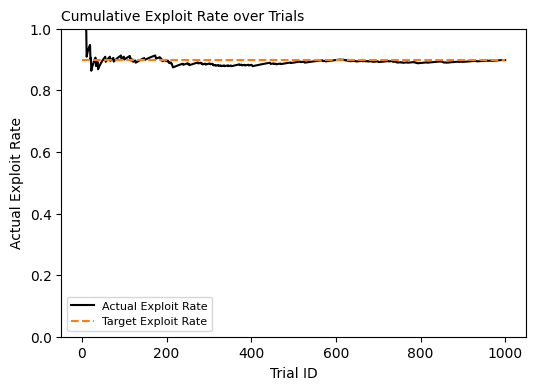

In [0]:
plot_exploit_rate_experiment(df_exp)

Next, we chart our save rate over time. Our *save rate* is the percent of times we have saved the shot _regardless of which goalkeeper faced the shot_. 

Our target here is 30% - the highest save rate among all the goalkeepers. If Neuer, our best goalkeeper, faced every shot, we would expect a save rate of about 30%. 

We can see that the longer the experiment goes on, the close we get to our target. This suggests that throughout the experiment we get better at identifying who the best goalkeeper is and selecting them to face the next shot when we exploit. We do, however, explore throughout the entire experiment, so with this method we would not expect to ever achieve a 30% save rate.

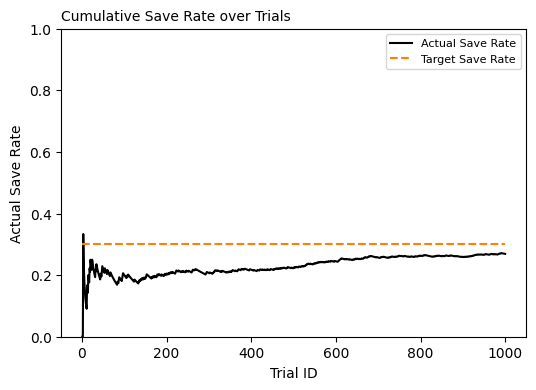

In [0]:
plot_save_rate_experiment(df_exp)

Remember that Neuer is our best goalkeeper. This chart shows the percent of shots that Neuer faces throughout the experiement.

Ideally, we would want our best goalkeeper to face every shot, so the target here is 100%. 

We can see that for the first 400 shots, we only choose Neuer about 10% of the time. This suggests we thought a different goalkeeper was superior and when we *exploited* we did not choose Neuer. After about 400 kicks, however, we correctly identified him and began having him face more shots. 

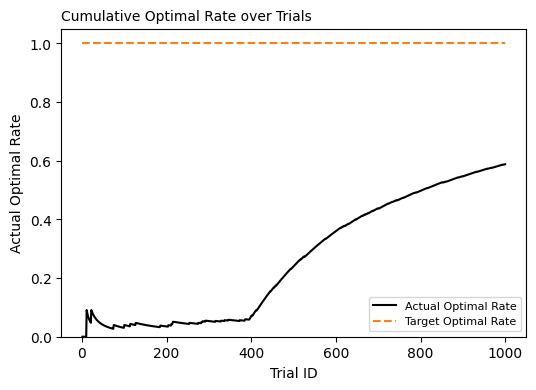

In [0]:
plot_optimal_rate_experiment(df_exp)

This chart shows the true save rate and estimated save rate for each goalkeeper over time. The dashed lines are the true rates and the sold lines are our estimates.

In this experiment, we can see that Buffon made a save early on while the others were scored on. This led us to believe Buffon had the best rate and have him face more shots. 

Casillas then made a couple saves around 75 shots in. This led us to believe he was the best goalkeeper. He, however, failed to save subsequent shots and his estimate dropped back below Buffon. 

Since we suspected Buffon and Casillas of better save rates, we actually selected Neuer so few times that he does not save a shot until the 200th shot of the experiment. With more shots, however, we see his estimated save rate climb. By the 400th shot of the experiement, his estimated save rate is above the other two goalkeepers. We continue to have him face more and more shots and his estimated save rate converges to his true 30% mark. 


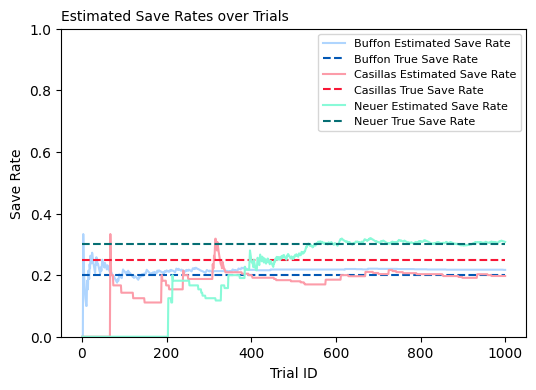

In [0]:
plot_p_est_experiment(df_exp)

This final chart shows who we thought was the best goalkeeper after each shot. So for example, if we had stopped our experiement after 10 trials, the bar is blue and we would have chosen Buffon as our top goalkeeper. If we had stopped after 320 trials, the bar is red and we would have selected Casillas as our best goalkeeper. After 500 trials, the bar is teal, and we would have selected Neuer.

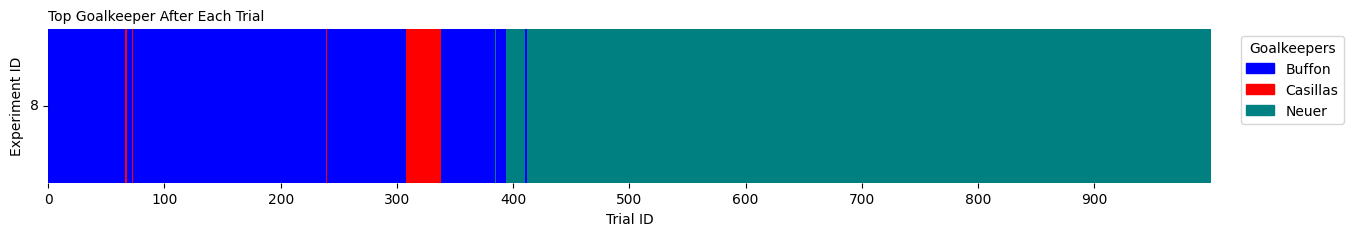

In [0]:
plot_top_goalkeeper_experiment(df_exp)

### Simulation Results

The above results were for one experiment and mimic what we will do in real life. Remember, though, that we did a simulation of 100 experiments. We can aggregate the results off all those experiments to estimate what a likely outcome for our real-life experiment will be.

We consolidate all the charts into a single graphic to summarize the whole simulation. Each chart is an extension of one above.

- The chart in the top left plots the **exploit rate**. Similar to the exploit rate chart for a single experiment, the target is still in orange at 90%. In this case, the black line is the _average exploit rate_ after the given _trial_id (shot)_ across _all 100 experiments_. The gray shading represents one standard deviation above and below the average.
- The chart in the top right plots the **save rate**. The orange is the target, the black is the average across all experiments, and the gray shading is a standard deviation above and below the average.
- The chat in the middle left plots the **optimal rate**. The orange is the target, the black is the average across all experiments, and the gray shading is a standard deviation above and below the average.
- The chart in the middle right plots the **estimated save rate for each goalkeeper**. Each dashed gray line represents the true save rate for one of the goalkeepers. The solid colored lines show the average estimated save rate across all experiments for each goalkeeper. The shading shows one standard deviation above and below the average for each goalkeeper.
- The chart in the bottom right (I know I'm going out of order but you'll see why when you keep reading) plots the **selected goalkeeper** after each trial for each experiment. Each row is one experiment and each column is a trial. The color indicates which goalkeeper we suspect has the best save rate after each trial
- The chart in the bottom left is a new chart and a derivative of the chart in the bottom right. The chart shows the _percent of experiments_ in which we would have chosen each goalkeeper after each trial.
    - For example, if we would have stopped each experiment in our simulation after 200 trials, we would have selected Buffon as our best goalkeeper in about 20% of experiments, Casillas as our best goalkeeper in about 25% of experiments, and Neuer as our best goalkeeper in about 55% of experiments.

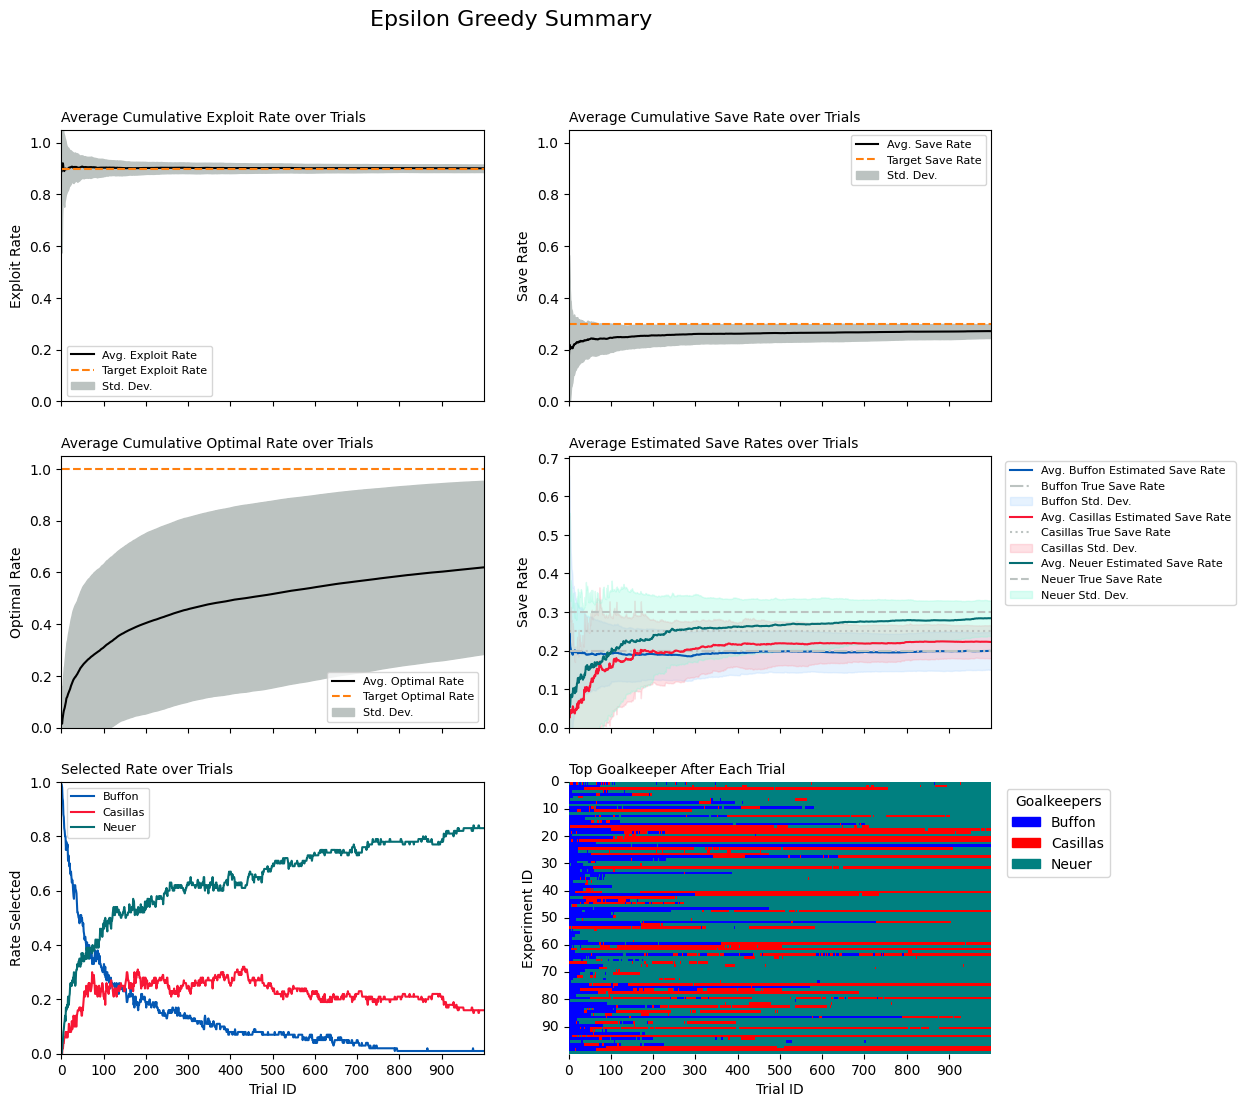

In [0]:
plot_simulation_summary(df_sim_eps, title='Epsilon Greedy Summary')

## Conclusion

The coach feels much better about this approach than the previous. Whereas the first method called for taking 4000 shots with an unsure outcome, this second method gives her some expectations. 

Assuming the save rates are different, but within 10%, she can expect that an experiment that is 1000 shots long will tell her the best goalkeeper about 80% of the time. An experiment 500 shots long will correctly tell her the best goalkeeper 60% of the time. 

Before the coach goes ahead with the experiment, the analyst has one caveat: _the results are highly dependent on the order we select the goalkeepers._ In the above simulation, in the case of a tie for estimated save rate, we choose Buffon. The analyst has run two other simulations, one with Casillas breaking the tie and one with Neuer.

In [0]:
#do two more simulations in a different order
gk_save_rates = [0.25, 0.3, 0.2]
gk_names = ['Casillas', 'Neuer', 'Buffon']
df_sim_eps_2 = simulation(num_experiments,num_trials,eps,gk_save_rates,gk_names)

gk_save_rates = [0.3, 0.2, 0.25]
gk_names = ['Neuer', 'Buffon','Casillas']
df_sim_eps_3 = simulation(num_experiments,num_trials,eps,gk_save_rates,gk_names)

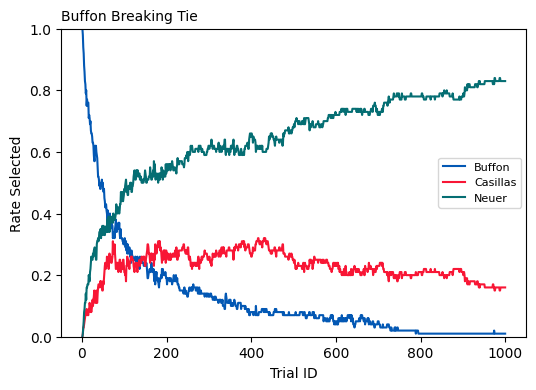

In [0]:
plot_top_goalkeeper_rate_simulation(df_sim_eps, 'Buffon Breaking Tie')

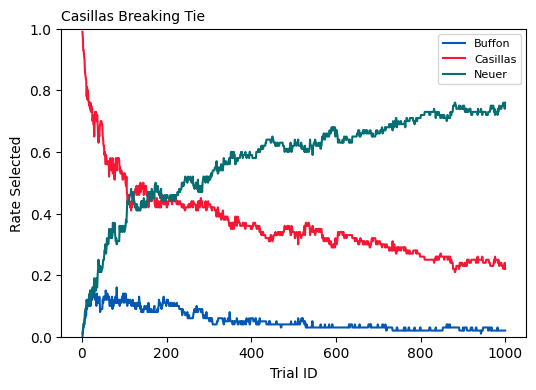

In [0]:
plot_top_goalkeeper_rate_simulation(df_sim_eps_2, 'Casillas Breaking Tie')

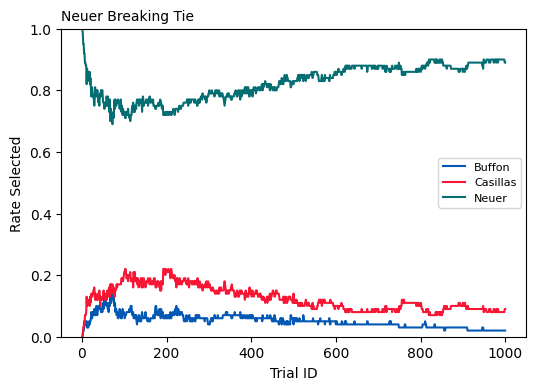

In [0]:
plot_top_goalkeeper_rate_simulation(df_sim_eps_3, 'Neuer Breaking Tie')

The results vary quite widely. The coach is much less enthused now with the approach. She will not know beforehand the true save rate of each goalkeeper and thus will not be able to choose a good order. 

The analyst suggests that we need to _explore_ more in the beginning of the experiment to establish some baseline save rates for each goalkeeper. That should make later results where we _exploit_ by choosing the best goalkeeper more stable.

There are a few ways to approach this. One would be changing the _epsilon_, or the rate at which we explore. We could make this higher, or we could use an epsilon that _decays_, meaning we would explore more at the beginning of the experiment and less at the end.

The analyst, however, has a different approach in mind...

# Approach 3: Optimistic Initial Values

The analyst proposes this modified experiment.

> Assume all goalkeepers have an impossibly high save rate (5, for example). For each shot, choose the goalkeeper with the highest estimated save rate to face the next shot.
- This forces the algorithm to explore early on. Even if the first goalkeeper saves the first shot (save rate = 1), their estimated save rate will fall from the initial estimate of 5. We will then select a different goalkeeper to face the next shot
- The higher the initial estimated save rate, the more we will explore early on 

## Simulation

### Code for Simulation

In [0]:
#set up a class to model each goalkeeper
class Goalkeeper_ov:
    def __init__(self, p, name):
        self.p = p #p is the true save rate
        self.p_estimate = 5 #start with an estimate of 5 that will come down
        self.N = 1 #samples collected so far, keeps initial estimate
        self.name = name #assign name to goalkeeper

    def face_shot(self):
        #save the shot with probability p
        return np.random.random() < self.p
    
    def update(self, x):
        #x is 0 or 1
        self.N += 1 #record the faced shot
        self.p_estimate = ((self.N - 1)*self.p_estimate + x) / self.N #update our estimate of p

In [0]:
def experiment_ov(num_trials, gk_save_rates, gk_names):
    """
    Run an optimistic values experiment

    num_trials (int): the number of trials in the experiment
    gk_save_rates (list of floats): the true save rates of each goalkeeper
    gk_names (list of strings): the names of each goalkeeper (must be same order as rates)

    df (dataframe): the results of the experiment 
    """

    #get a list of all goalkeepers
    gks = [Goalkeeper_ov(p, name) for p, name in zip(gk_save_rates, gk_names)]

    #initialize results
    trial_ids = []
    exploit_results = []
    gk_results = []
    save_results = []
    p_est_results = []
    chosen_results = []
     
    #For each trial in the experiment, we exploit, select gk, and face the shot
    for i in range(num_trials):
        #SELECT GK
        trial_ids.append(i+1) #record trial id

        exploit_results.append(True) #recrod exploit
        gk_selected = np.argmax([gk.p_estimate for gk in gks]) #choose gk with current best rate
        gk_results.append(gks[gk_selected].name) #record which gk we selected

        #FACE THE SHOT

        #face the shot. 1 if a save, 0 if a goal
        save = gks[gk_selected].face_shot()
        #udpate results array
        save_results.append(save)
        #update the estimate of gk save rate
        gks[gk_selected].update(save)
        #record estimates
        p_est_results.append([gk.p_estimate for gk in gks])
        #record chosen gk after this trial
        chosen_results.append(gks[np.argmax([gk.p_estimate for gk in gks])].name)

    #determine array of optimal choice
    opt = gks[np.argmax([gk.p for gk in gks])].name #optimal gk
    opt_results = [g == opt for g in gk_results]
    
    #compile results in a dataframe
    df = pd.DataFrame({
        **{
            'trial_id': trial_ids,
            'exploit': exploit_results,
            'goalkeeper': gk_results,
            'optimal_goalkeeper': opt_results,
            'save': save_results,
            },
        **{gks[i].name+'_est_p': [x[i] for x in p_est_results] for i in range(len(gks))},
        **{
            'top_goalkeeper': chosen_results,
            }
        }
                      )
    
    #add true save rates
    for g in gks:
        df[g.name+'_p'] = g.p
    
    #Add cumulative results
    df['cumulative_exploit'] = df['exploit'].cumsum()
    df['cumulative_exploit_rate'] = df['cumulative_exploit'] / df['trial_id']
    df['target_exploit_rate'] = 1
    df['cumulative_optimal_goalkeeper'] = df['optimal_goalkeeper'].cumsum()
    df['cumulative_optimal_rate'] = df['cumulative_optimal_goalkeeper'] / df['trial_id']
    df['target_optimal_rate'] = 1
    df['cumulative_saves'] = df['save'].cumsum()
    df['cumulative_save_rate'] = df['cumulative_saves'] / df['trial_id']
    df['target_save_rate'] = np.max([gk.p for gk in gks])
    
    #record parameters
    df['num_trials'] = num_trials
    
    return df

In [0]:
def simulation_ov(num_experiments, num_trials, gk_save_rates, gk_names):
    """
    Run a simulation of optimistic values experiments

    num_experiments (int): the number of experiments in the simulation
    num_trials (int): the number of trials per experiment
    gk_save_rates (list of floats): the true save rates of each goalkeeper
    gk_names (list of strings): the names of each goalkeeper (must be same order as rates)

    sim_df (dataframe): the results of the simulation 
    """

    #initialize df
    i = 1
    np.random.seed(i) #set seed
    sim_df = experiment_ov(num_trials, gk_save_rates, gk_names)
    sim_df['experiment_id'] = i

    #iterate through other trials
    for i in range(1, num_experiments):
        np.random.seed(i+1)  #set seed
        df = experiment_ov(num_trials, gk_save_rates, gk_names)
        df['experiment_id'] = i+1
        sim_df = pd.concat([sim_df, df])

    return sim_df


### Run Simulation

In [0]:
#set parameters for the simulation
num_experiments = 100
num_trials = 1000
gk_save_rates = [0.2, 0.25, 0.3]
gk_names = ['Buffon', 'Casillas', 'Neuer']

df_sim_ov = simulation_ov(num_experiments,num_trials,gk_save_rates,gk_names)


#do two more simulations in a different order
gk_save_rates = [0.25, 0.3, 0.2]
gk_names = ['Casillas', 'Neuer', 'Buffon']
df_sim_ov_2 = simulation_ov(num_experiments,num_trials,gk_save_rates,gk_names)

gk_save_rates = [0.3, 0.2, 0.25]
gk_names = ['Neuer', 'Buffon','Casillas']
df_sim_ov_3 = simulation_ov(num_experiments,num_trials,gk_save_rates,gk_names)

## Results

The analyst finds some notable results in the new approach:

- The chart in the top left shows we are no longer using epsilon to explore
- The chart if the top right shows we get much closer to our target true save rate with this method.
- The chart in the middle right shows the estimated save rates starting at 5 and coming down to the true save rates.
  - Here, though, we see that the rates for Casillas and Buffon do not converge to their true rates. Instead, as soon as the estimates drop below Neuer, that stay constant since we no longer exlore those goalkeepers.


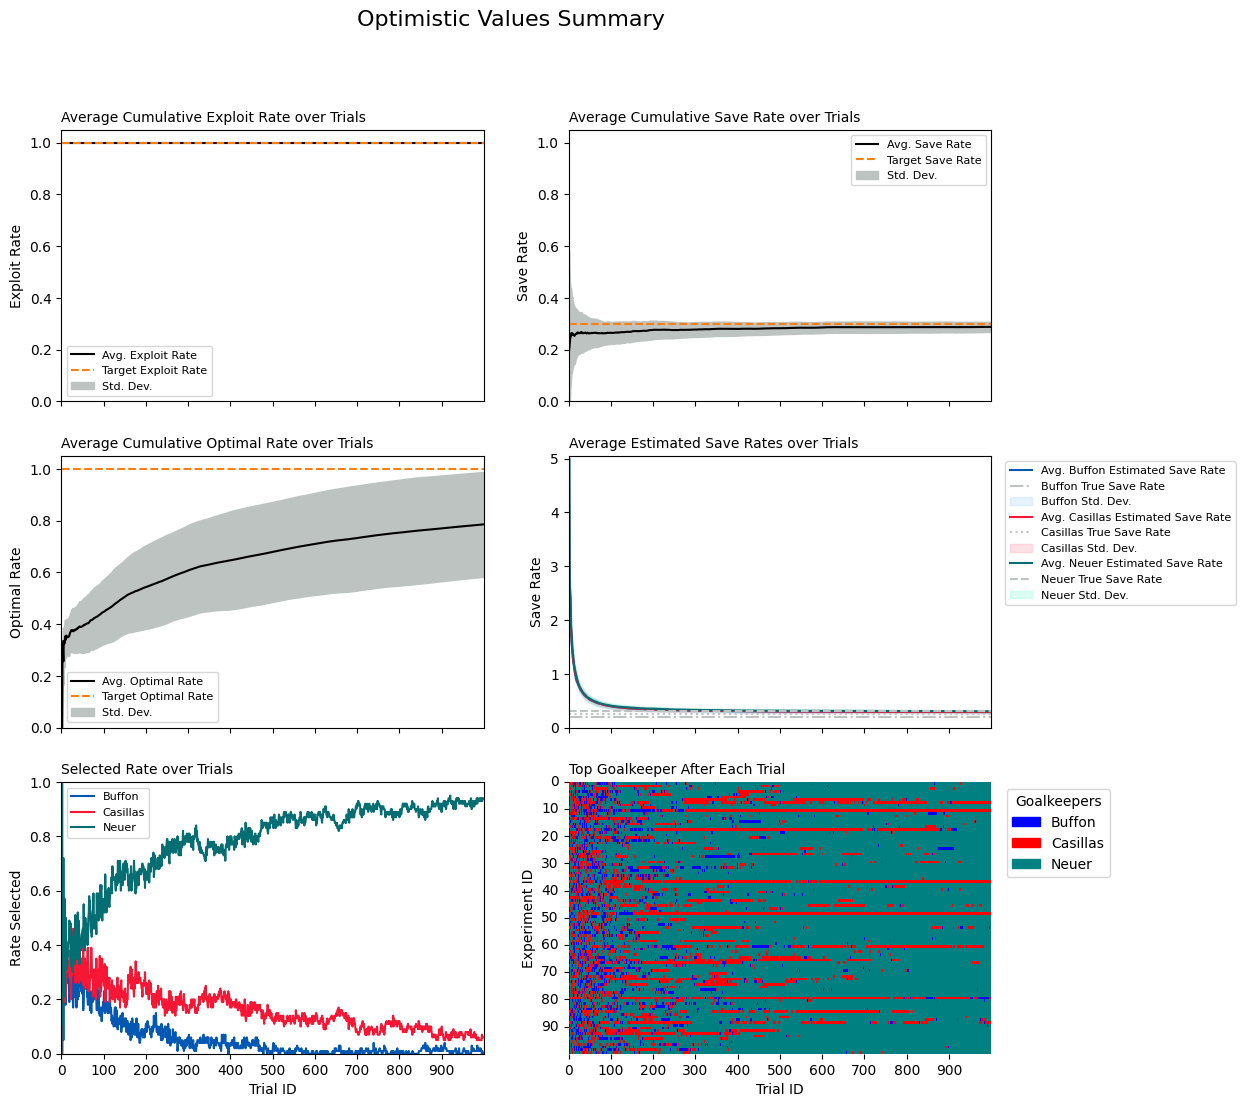

In [0]:
plot_simulation_summary(df_sim_ov, 'Optimistic Values Summary')

### Optimal Rate
Let's do a deep dive on the optimal rate chart (middle left above).

- With the optimistic values approach, we begin selecting the correct goalkeepr much quicker.
  - With the epsilon greedy approach, it takes about 200 trials to select the correct goalkeeper 40% of the time. By contrast, it takes about 50 trials with the optimistic values approach
- Our uncertainty using the second method is much smaller, meaning we can be much more confident in our estimate using the second approach.

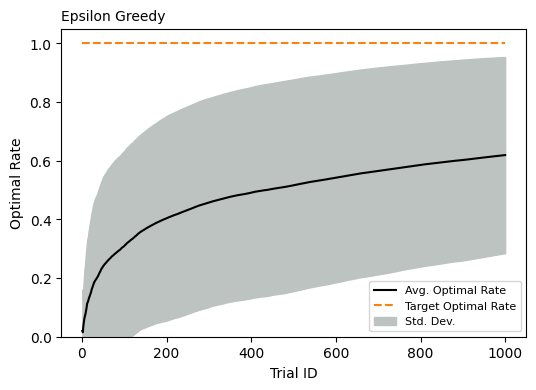

In [0]:
plot_optimal_rate_simulation(df_sim_eps, 'Epsilon Greedy')

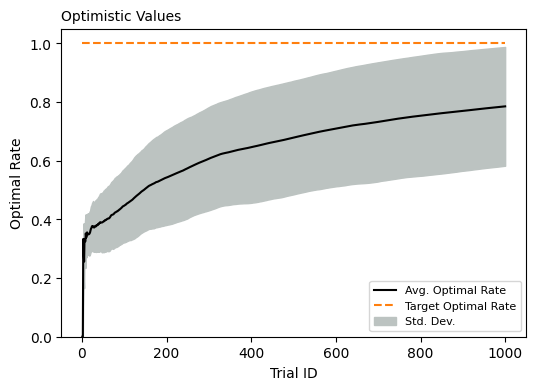

In [0]:
plot_optimal_rate_simulation(df_sim_ov, 'Optimistic Values')

### Order Issue
Now, let's check if we still get varied results when changing the order of the goalkeepers

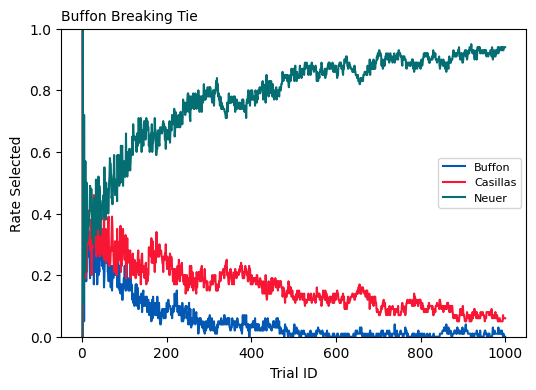

In [0]:
plot_top_goalkeeper_rate_simulation(df_sim_ov, 'Buffon Breaking Tie')

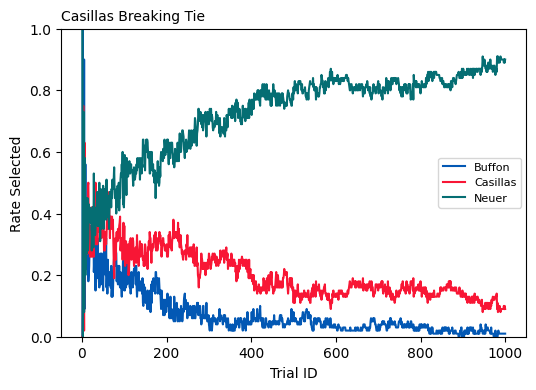

In [0]:
plot_top_goalkeeper_rate_simulation(df_sim_ov_2, 'Casillas Breaking Tie')

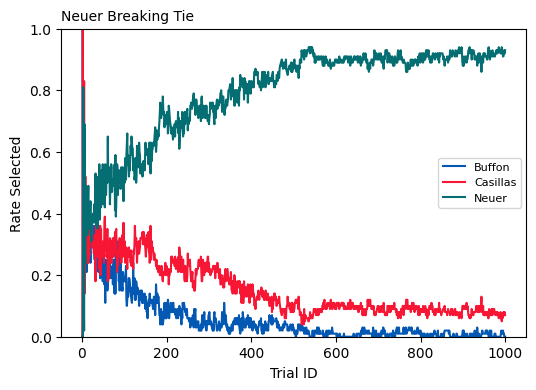

In [0]:
plot_top_goalkeeper_rate_simulation(df_sim_ov_3, 'Neuer Breaking Tie')

While there is slight variation, we can see that our results are independent of the order we put the goalkeepers in. This method solved our issue!

## Conclusion
Is this new method solving our use case of selecting the base goalkeeper?

In the Epsilon Greedy Method, after taking 500 shots we, on average, selected Neuer as our best goakeeper 60% of the time. 

Using the Optimistic Values Method, we, on average, identify Neuer correctly 80% of the time after 500 shots. This is a significant improvement.

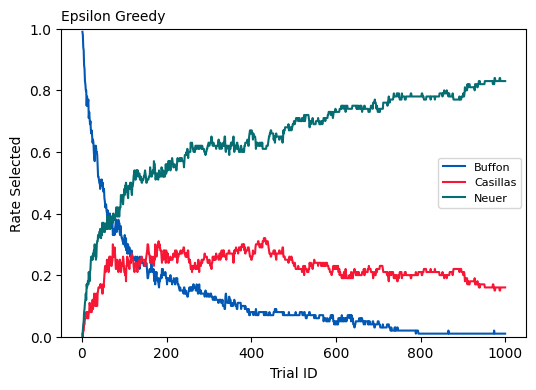

In [0]:
plot_top_goalkeeper_rate_simulation(df_sim_eps, 'Epsilon Greedy')

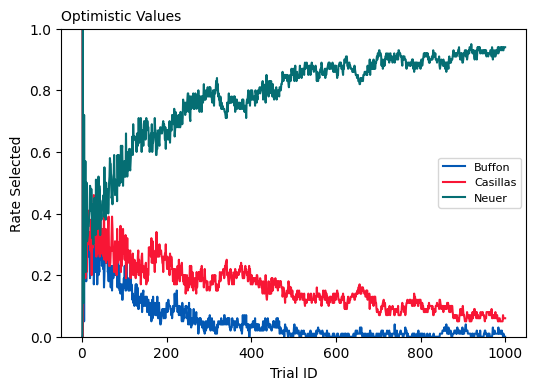

In [0]:
plot_top_goalkeeper_rate_simulation(df_sim_ov, 'Optimistic Values')

The analyst is pleased with the results. One drawback, however, is that this method does not estimate the true save rates of all goalkeepers. Instead, only the estimate for the top goalkeeper converges to the true rate. 

The analyst wants to solve this issue before chatting with the coach again. He turns to a new method...

# Approach 4: UCB1